In [1]:
import import_ipynb
import numpy as np
import copy
import maze_env as env

importing Jupyter notebook from maze_env.ipynb


In [2]:
n_states=90;n_actions=4;

In [3]:
policy = np.ones((n_states, n_actions)) / n_actions
visited=copy.deepcopy(env.matrix)

In [4]:
visited

[['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'],
 ['1', '.', '.', '.', '.', '.', '.', '.', '.', '.', '1', '.', '1', '.', '1'],
 ['1', '.', 'E', '1', '1', '.', '1', '1', '1', '1', '1', '.', '.', '.', '1'],
 ['1', '.', '.', '.', '1', '.', '1', '1', '1', '1', '1', '.', '1', '1', '1'],
 ['1', '1', '1', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'S', '.', '1'],
 ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']]

In [5]:
def generate_session(policy,t_max=10**2):
    states,actions = [],[]
    total_reward = 0
    env.mat=copy.deepcopy(env.matrix)
    s=env.reset()
    done=0
    for t in range(t_max):
        done=-1
        a=0;r=0
        new_s=[0,1]
        while(done==-1):
            a = np.random.choice(len(policy[s]), p=policy[s])
            done,new_s, r = env.step(a,t)
        visited[new_s[0]][new_s[1]]='X';
        #env.show()
        #print("|",end="\n")
        states.append(s)
        actions.append(a)
        total_reward += r
        #print(r,end=":");
        s=int(new_s[0]*15)+int(new_s[1])
        if done==1:
            break
    #print(total_reward);
    return states, actions, total_reward

In [6]:
visited=copy.deepcopy(env.matrix)
print(generate_session(policy,100)[-1]);
visited

-682


[['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'],
 ['1', '.', '.', '.', '.', '.', '.', '.', '.', '.', '1', 'X', '1', 'X', '1'],
 ['1', '.', 'E', '1', '1', '.', '1', '1', '1', '1', '1', 'X', 'X', 'X', '1'],
 ['1', '.', '.', '.', '1', '.', '1', '1', '1', '1', '1', 'X', '1', '1', '1'],
 ['1', '1', '1', '.', '.', '.', '.', '.', 'X', 'X', 'X', 'X', 'X', 'X', '1'],
 ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']]

In [7]:
import matplotlib.pyplot as plt
sample_rewards = [generate_session(policy,t_max=100)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [8]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states  = [s for i in range(len(states_batch)) if rewards_batch[i] >= reward_threshold for s in states_batch[i]]
    elite_actions = [a for i in range(len(actions_batch)) if rewards_batch[i] >= reward_threshold for a in actions_batch[i]]
    
    return elite_states,elite_actions

In [9]:
from collections import defaultdict
def update_policy(elite_states,elite_actions):
    new_policy = np.zeros([n_states,n_actions])
    visited_states = set(elite_states)
    counts = defaultdict(lambda: [0]*n_actions)
    for state, action in zip(elite_states, elite_actions):
        counts[state][action] += 1
    for state in range(n_states):
        if state in visited_states:
            new_policy[state] = [count / sum(counts[state]) for count in counts[state]]
        else:
            new_policy[state] = [1 / n_actions] * n_actions    
    
    return new_policy

In [10]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards,range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [11]:
policy=np.ones([n_states,n_actions])/n_actions

mean reward = 941.028, threshold=995.100


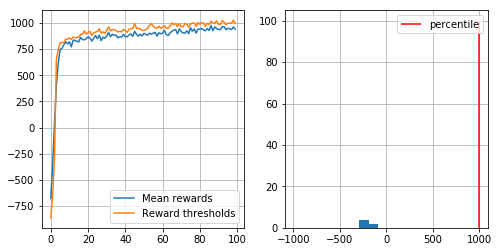

In [12]:
n_sessions = 250 #sample this many sessions
percentile = 45  #take this percent of session with highest rewards
learning_rate = 0.6 #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    batch_states,batch_actions,batch_rewards = zip(*sessions)

    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile)
    
    new_policy = update_policy(elite_states, elite_actions)
    
    policy = learning_rate * new_policy + (1-learning_rate) * policy
    #display results on chart
    show_progress(batch_rewards, log, percentile)

In [13]:
visited=copy.deepcopy(env.matrix)
print(generate_session(policy,100)[-1]);
visited

1133


[['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'],
 ['1', 'X', 'X', '.', '.', '.', '.', '.', '.', '.', '1', '.', '1', '.', '1'],
 ['1', 'X', 'E', '1', '1', '.', '1', '1', '1', '1', '1', '.', '.', '.', '1'],
 ['1', 'X', 'X', 'X', '1', '.', '1', '1', '1', '1', '1', '.', '1', '1', '1'],
 ['1', '1', '1', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'S', '.', '1'],
 ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']]